프레임워크
- Langchain
- 비슷한 역할을 하는 Llamaindex 등이 있는데, 학습 단계에서는 이들이 유용하지만, 실제 서빙을 위한 서비스를 개발하다 보면 하나 둘 직접 구현하게 되는 경우가 많음.

모델
- gpt-4o-mini
- Langchain ChatOllama 를 활용하면 Langchain 위에 첫날 실습한 Ollama + Local model 을 활용해서 구현할 수 있음

In [ ]:
%%capture --no-stderr
%pip install langchain langchain-openai langchain-openai langchain_chroma langchain-text-splitters langchain_community

In [ ]:
import getpass
import os

os.environ["OPENAI_API_KEY"] = getpass.getpass()

from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4o")

··········


**기본 RAG tutorial**

Langchain 에 익숙하지 않으신 분은 아래 링크의 튜토리얼 코드를 한 번 읽고 이해한 다음 아래 과정을 진행해주세요.

(tutorial 에서 이해되지 않는 부분은 강사/조교에게 질문해주세요!)

https://python.langchain.com/v0.2/docs/tutorials/rag/


## Langsmith API

Langsmith API 발급
https://docs.smith.langchain.com/administration/how_to_guides/organization_management/create_account_api_key

In [ ]:
import getpass
import os

os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_API_KEY"] = getpass.getpass()


··········


langchain hub 에서 prompt format 가져다 쓰기

In [5]:
from langchain import hub

prompt = hub.pull("rlm/rag-prompt")

example_messages = prompt.invoke(
    {"context": "filler context", "question": "filler question"}
).to_messages()

example_messages

[HumanMessage(content="You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.\nQuestion: filler question \nContext: filler context \nAnswer:", additional_kwargs={}, response_metadata={})]

In [6]:
import bs4
from langchain import hub
from langchain_chroma import Chroma
from langchain_community.document_loaders import WebBaseLoader
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough
from langchain_openai import OpenAIEmbeddings
from langchain_text_splitters import RecursiveCharacterTextSplitter
import requests

# Load, chunk and index the contents of the blog.

session = requests.Session()
session.headers.update({
    "User-Agent": "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36"
})

url_list = ['2023-06-23-agent/', '2023-03-15-prompt-engineering/', '2023-10-25-adv-attack-llm/']
docs = {}
for paths in url_list:
    loader = WebBaseLoader(
        web_paths=("https://lilianweng.github.io/posts/"+paths,),
        session=session,  # 여기에 session 전달
        bs_kwargs=dict(
            parse_only=bs4.SoupStrainer(
                class_=("post-content", "post-title", "post-header")
            )
        ),
    )

    docs[paths] = loader.load()
    text_splitter = RecursiveCharacterTextSplitter(separators=["\n\n", "\n\n\n"],chunk_size=2000, chunk_overlap=200, length_function=len,
                                                   is_separator_regex=False)
    splits = text_splitter.split_documents(docs[paths])

splits[0]

Document(metadata={'source': 'https://lilianweng.github.io/posts/2023-10-25-adv-attack-llm/'}, page_content='Adversarial Attacks on LLMs\n    \nDate: October 25, 2023  |  Estimated Reading Time: 33 min  |  Author: Lilian Weng\n\n\nThe use of large language models in the real world has strongly accelerated by the launch of ChatGPT. We (including my team at OpenAI, shoutout to them) have invested a lot of effort to build default safe behavior into the model during the alignment process (e.g. via RLHF). However, adversarial attacks or jailbreak prompts could potentially trigger the model to output something undesired.\nA large body of ground work on adversarial attacks is on images, and differently it operates in the continuous, high-dimensional space. Attacks for discrete data like text have been considered to be a lot more challenging, due to lack of direct gradient signals. My past post on Controllable Text Generation is quite relevant to this topic, as attacking LLMs is essentially to

agent 에 대한 post 를 load, split 한 뒤 vectorstore 생성하고, langchain hub 에서 가져온 프롬프트 포맷을 활용해 Task decomposition 이라는 입력 프롬프트에 대한 답변 확인하기

In [7]:
import bs4
from langchain import hub
from langchain_chroma import Chroma
from langchain_community.document_loaders import WebBaseLoader
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough
from langchain_openai import OpenAIEmbeddings
from langchain_text_splitters import RecursiveCharacterTextSplitter

# Load, chunk and index the contents of the blog.
loader = WebBaseLoader(
    web_paths=("https://lilianweng.github.io/posts/2023-06-23-agent/",),
    bs_kwargs=dict(
        parse_only=bs4.SoupStrainer(
            class_=("post-content", "post-title", "post-header")
        )
    ),
)
docs = loader.load()

text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
splits = text_splitter.split_documents(docs)
vectorstore = Chroma.from_documents(documents=splits, embedding=OpenAIEmbeddings())

# Retrieve and generate using the relevant snippets of the blog.
retriever = vectorstore.as_retriever()
prompt = hub.pull("rlm/rag-prompt")

def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)


rag_chain = (
    {"context": retriever | format_docs, "question": RunnablePassthrough()}
    | prompt
    | llm
    | StrOutputParser()
)

rag_chain.invoke("What is Task Decomposition?")

'Task decomposition is the process of breaking down a complex task into smaller, simpler steps to make it more manageable and enhance model performance. Techniques like Chain of Thought (CoT) and Tree of Thoughts further elaborate on this by structuring reasoning into these smaller steps, allowing multiple reasoning paths. It can be achieved through methods like simple prompting, task-specific instructions, or human input.'

## Langsmith 써서 실행 과정/결과 모니터링하기

https://smith.langchain.com/

아래부터는 직접 Task 를 읽고, 문서를 읽고, 코드를 작성, 평가하면서 task 를 풀어보세요.

Task 를 순서대로 하고 나면 아래 이미지와 같이 RAG chain 이 완성됩니다.

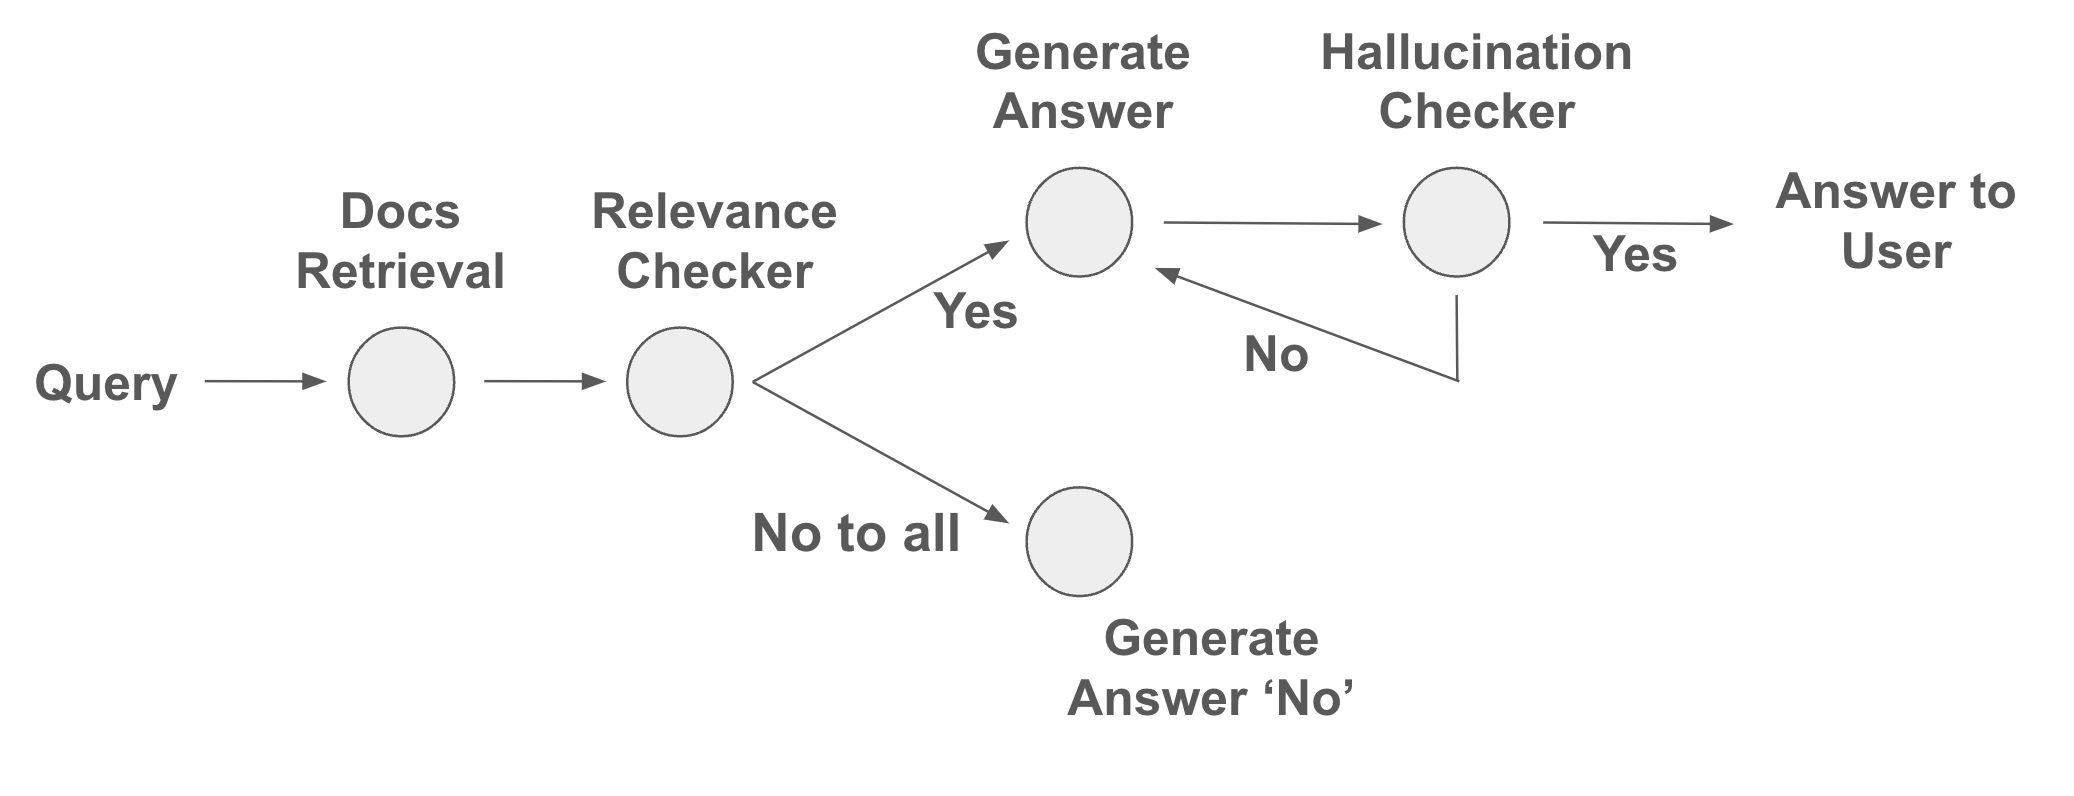

아래 1-10 task 에 대한 코드를, 각각의 task별 참고 링크를 보면서 작성해보세요.

**1. 3개의 블로그 포스팅 본문을 Load하기 : WebBaseLoader 활용**

https://python.langchain.com/v0.2/docs/integrations/document_loaders/web_base/

In [8]:
urls = [
    "https://lilianweng.github.io/posts/2023-06-23-agent/",
    "https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/",
    "https://lilianweng.github.io/posts/2023-10-25-adv-attack-llm/",
]

In [11]:
%pip install -qU langchain_community beautifulsoup4

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.1/105.1 kB 6.9 MB/s eta 0:00:00


In [72]:
from langchain_community.document_loaders import WebBaseLoader

loader_multiple_pages = WebBaseLoader(urls)
docs = loader_multiple_pages.load()
len(docs)

3

**2. 불러온 본문을 Split (Chunking) : recursive text splitter 활용 (아래 링크 참고)**

https://python.langchain.com/v0.2/docs/how_to/recursive_text_splitter/

In [10]:
%pip install -qU langchain-text-splitters

In [61]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    # Set a really small chunk size, just to show.
    chunk_size=100,
    chunk_overlap=20,
    length_function=len,
    is_separator_regex=False,
)
texts = text_splitter.split_documents(docs)
len(texts)

1746

**3. Chunks 를 임베딩하여 Vector store 저장: openai 임베딩, chroma vectorstore 사용**

이 때,

embedding model 은 "text-embedding-3-small" 사용

embedding: https://python.langchain.com/v0.2/docs/integrations/text_embedding/openai/

vetor store: https://python.langchain.com/v0.2/docs/integrations/vectorstores/chroma/

retriever search_type 은 'similarity', search_kwargs={'k': 6} 을 사용해주세요.

In [38]:
%pip install -qU langchain-openai

In [62]:
from langchain_openai import OpenAIEmbeddings

embeddings = OpenAIEmbeddings(
    model="text-embedding-3-large",
    # With the `text-embedding-3` class
    # of models, you can specify the size
    # of the embeddings you want returned.
    # dimensions=1024
)

In [18]:
%pip install -qU langchain-openai

In [82]:
from langchain_chroma import Chroma

vector_store = Chroma(
    collection_name="example_collection",
    embedding_function=embeddings,
    persist_directory="./my_chroma_langchain_db",  # Where to save data locally, remove if not neccesary
)

In [83]:
from uuid import uuid4
from langchain_core.documents import Document

uuids = [str(uuid4()) for _ in range(len(texts))]

vector_store.add_documents(documents=texts, ids=uuids)

['3472d4de-5cf3-4773-923a-922aeb4c30c8',
 '0ee9a433-b52e-4857-aaed-e9ee1c130108',
 'da77e56e-7847-445c-9516-e1bad940f916',
 '9f780ce2-dce8-4f7d-89e6-7503a54f11e4',
 '01ad6690-6ec1-4a77-9820-137fc0824688',
 'f9e2d884-fc67-40e2-9c34-84747559adea',
 'a1e037f2-96af-4066-8c2f-5604c743b2d0',
 'db2871f4-d0e1-4984-938a-b6f7d3347818',
 'e2ac4c78-0e5e-454d-8e63-e77e011bd97f',
 '150092b8-a5dc-47cc-b34e-b4eabbfd333e',
 '9c89ff1b-0d7b-4b10-a51f-e5c76571fa89',
 '7ccccc7a-4949-469e-8e42-b87bdefbc070',
 'f5fa9fde-3380-4b07-8a4c-f6186c6a9add',
 'fe82cff9-9c64-48a5-aa93-f6889614d6dd',
 '0948a61a-0d28-4658-a7e9-566c8305c698',
 '7dbf23e3-bea6-42fe-9830-b3b97176210b',
 '4f91e32d-c104-4781-82bb-08e0b2c9599b',
 '252ad33e-a595-4d41-8c19-14d9e7d6ab40',
 '97b83c5e-f373-47de-b2f4-43c34ce4c242',
 '9c4c7478-f740-4bd7-8f0d-3c191a83a421',
 'd1e7418b-e5e7-485d-951c-154e26910bd1',
 'dce4afe1-17e5-4741-af7b-bbf6c42da39a',
 '68a0c33d-768a-4172-9718-734a6c3170eb',
 'b9836cdf-2094-426e-9f7b-24bb91eb5354',
 '807eeb5c-ce48-

**4. User query = ‘agent memory’ 를 받아 관련된 chunks를 retrieve**


https://python.langchain.com/v0.2/docs/how_to/vectorstore_retriever/

https://api.python.langchain.com/en/latest/vectorstores/langchain_core.vectorstores.VectorStore.html#langchain_core.vectorstores.VectorStore.as_retriever

In [91]:
retriever = vector_store.as_retriever()

docs = retriever.invoke("Why has AI fallen down?")
docs

[Document(id='17b34b54-8532-44b5-9fc2-a06c36913c72', metadata={'title': "Prompt Engineering | Lil'Log", 'description': 'Prompt Engineering, also known as In-Context Prompting, refers to methods for how to communicate with LLM to steer its behavior for desired outcomes without updating the model weights. It is an empirical science and the effect of prompt engineering methods can vary a lot among models, thus requiring heavy experimentation and heuristics.\nThis post only focuses on prompt engineering for autoregressive language models, so nothing with Cloze tests, image generation or multimodality models. At its core, the goal of prompt engineering is about alignment and model steerability. Check my previous post on controllable text generation.', 'language': 'en', 'source': 'https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/'}, page_content='via Google Search, its performance on post-2020 questions are still a lot worse than on pre-2020'),
 Document(id='da6dfa52-02f9-462

**5. 5-1) 과 5-2) 를 참고하여, User query와 retrieved chunk 에 대해 relevance 가 있는지를 평가하는 시스템 프롬프트를 작성해보세요: retrieval 퀄리티를 LLM 이 스스로 평가하도록 하고, 관련이 있으면 {‘relevance’: ‘yes’} 관련이 없으면 {‘relevance’: ‘no’} 라고 출력하도록 함. ( JsonOutputParser() 를 활용 )**


5-1 참고) RAG 용 프롬프트 작성을 위한 Prompt Hub 활용

https://smith.langchain.com/hub/rlm/rag-prompt

In [74]:
from langchain import hub

prompt = hub.pull("rlm/rag-prompt")
prompt

ChatPromptTemplate(input_variables=['context', 'question'], input_types={}, partial_variables={}, metadata={'lc_hub_owner': 'rlm', 'lc_hub_repo': 'rag-prompt', 'lc_hub_commit_hash': '50442af133e61576e74536c6556cefe1fac147cad032f4377b60c436e6cdcb6e'}, messages=[HumanMessagePromptTemplate(prompt=PromptTemplate(input_variables=['context', 'question'], input_types={}, partial_variables={}, template="You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.\nQuestion: {question} \nContext: {context} \nAnswer:"), additional_kwargs={})])

In [75]:
example_messages = prompt.invoke(
    {"context": "filler context", "question": "filler question"}
).to_messages()

example_messages

[HumanMessage(content="You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.\nQuestion: filler question \nContext: filler context \nAnswer:", additional_kwargs={}, response_metadata={})]

5-2 참고) output JSON formatting 하는 코드

https://python.langchain.com/v0.2/docs/how_to/output_parser_json/#without-pydantic

In [65]:
import getpass
import os

os.environ["OPENAI_API_KEY"] = getpass.getpass()

from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4o")

··········


In [92]:
from langchain_core.output_parsers import JsonOutputParser
from langchain_core.prompts import PromptTemplate

def relevantChecker(inputs: dict):
  parser = JsonOutputParser()

  prompt = PromptTemplate(
      template="""
      Determine whether the context is relevant to the question.
      If relevant, respond only with {{"relevance": "yes"}}.
      If not relevant, respond only with {{"relevance": "no"}}.
      {format_instructions}
      question: {question}
      document: {document}
      """,
      input_variables=["question", "document"],
      partial_variables={"format_instructions": parser.get_format_instructions()},
  )

  chain = prompt | llm | parser
  return chain.invoke(inputs)

```
{'response': "Sure! Here's a joke for you: Why couldn't the bicycle stand up by itself? Because it was two tired!"}
```

6. 5 에서 모든 docs에 대해 'yes' 가 나와야 하는 케이스와 ‘no’ 가 나와야 하는 케이스를 작성해보세요.

In [93]:
yes_questions = [
    "Q1: What role does the “Planning” component play in an LLM-based autonomous agent system?",
    "Q2: What types of “Memory” components exist, and how are they utilized?",
    "Q3: What exactly does “Prompt Engineering” mean?",
    "Q4: What is the difference between Zero-Shot and Few-Shot prompting approaches?",
    "Q5: In the context of adversarial attacks on text, what is “token manipulation”?",
    "Q6: What is the difference between white-box and black-box attacks?"
    ]
no_questions = [
    "Q1: What are the major differences between supervised learning and reinforcement learning in training neural networks?",
    "Q2: How does the MapReduce programming model work in distributed computing systems?",
    "Q3: What are the main challenges in implementing quantum error correction for quantum computers?",
    "Q4: How do convolutional neural networks (CNNs) process image data differently from recurrent neural networks (RNNs)?",
    "Q5: What role does consensus play in blockchain systems, and how do algorithms like Proof-of-Stake differ from Proof-of-Work?",
    "Q6: What are the key differences between IPv4 and IPv6 in terms of address structure and routing?"
]

In [94]:
yes_dicts = []
for question in yes_questions:
  yes_dicts.append({"question": question, "document": retriever.invoke(question)})
no_dicts = []
for question in no_questions:
  no_dicts.append({"question": question, "document": retriever.invoke(question)})

In [88]:
print(yes_dicts)
print(no_dicts)

[{'question': 'Q1: What role does the “Planning” component play in an LLM-based autonomous agent system?', 'document': [Document(id='4a39f2a6-c24c-4fe0-8a41-e3f475914c04', metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'}, page_content='LLM Powered Autonomous Agents\n    \nDate: June 23, 2023  |  Estimated Reading Time: 31 min  |  Author: Lilian Weng\n\n\nBuilding agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.\nAgent System Overview#\nIn a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components:\n\nPlanning\n\nSubgoal and decomposition: The agent breaks down large tasks into smaller, manageable subgoals, enabling ef

In [95]:
for yes_dict in yes_dicts:
  print(relevantChecker(yes_dict))

{'relevance': 'yes'}
{'relevance': 'yes'}
{'relevance': 'yes'}
{'relevance': 'yes'}
{'relevance': 'yes'}
{'relevance': 'yes'}


In [96]:
for no_dict in no_dicts:
  print(relevantChecker(no_dict))

{'relevance': 'no'}
{'relevance': 'no'}
{'relevance': 'no'}
{'relevance': 'no'}
{'relevance': 'no'}
{'relevance': 'no'}


7. 6에서 케이스별로 의도한 결과 ('yes' 또는 'no' )와 일치하는 답변이 나오는지 확인해보세요.
 정답대로 나오지 않는다면 문제를 찾아 디버깅해보세요. (Splitter, Chunk size, overlap, embedding model, vector store, retrieval 평가 시스템 프롬프트 등) 디버깅이 어려운 경우,  강사/조교에게 질문해주세요.

8. 6-7 의 평가에서 문제가 없다면, 5에서 작성한 코드의 실행 결과가 'yes' 인 경우, 4의 retrieved chunk 를 가지고 답변하는 chain 코드를 작성해주세요. (prompt | llm | parser 형태의 코드)

In [ ]:
# 8 을 수행하기 위한 참고 코드
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough

def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

rag_chain = (
    {"context": retriever | format_docs, "question": RunnablePassthrough()}
    | prompt
    | llm
    | StrOutputParser()
)

for chunk in rag_chain.stream("What is Task Decomposition?"):
    print(chunk, end="", flush=True)

Task decomposition is the process of breaking down a complex task into smaller, more manageable sub-tasks or steps. This can be achieved through methods like prompting an LLM for steps, using task-specific instructions, or incorporating human input. Techniques such as Chain of Thought and Tree of Thoughts further enhance this process by structuring reasoning and exploring multiple possibilities.

9. 생성된 답안에 Hallucination 이 있는지 평가하는 시스템 프롬프트를 작성해보세요. LLM이 스스로 평가하도록 하고, hallucination 이 있으면 {‘hallucination’: ‘yes’} 없으면 {‘hallucination’: ‘no’} 라고 출력하도록 하세요.

In [100]:
from langchain_core.output_parsers import JsonOutputParser
from langchain_core.prompts import PromptTemplate

def hallucinationChecker(inputs: dict):
  parser = JsonOutputParser()

  prompt = PromptTemplate(
      template="""
  You are a rigorous fact-checker.

  Task:
  Evaluate whether the model's answer contains hallucinations with respect to the provided context.

  Definition:
  - A "hallucination" is any claim in the answer that is (a) contradicted by the context, or (b) not supported by the context while being presented as fact (fabricated entities, numbers, citations, or unverifiable specifics).

  Decision rules:
  1) Read the question, the context, and the answer carefully.
  2) If ANY key claim in the answer is unsupported or contradicted by the context → output {{"hallucination": "yes"}}.
  3) If all factual claims in the answer are supported by the context (or the answer clearly says there isn't enough info) → output {{"hallucination": "no"}}.
  4) If the context is unrelated or empty but the answer still asserts specifics as facts → output {{"hallucination": "yes"}}.

  Output format:
  - Respond ONLY with exactly one of the following JSON objects:
    - {{"hallucination": "yes"}}
    - {{"hallucination": "no"}}

  {format_instructions}
  question: {question}
  context: {document}
  answer: {answer}
  """,
    input_variables=["question", "document", "answer"],
    partial_variables={"format_instructions": parser.get_format_instructions()},
  )

  chain = prompt | llm | parser
  return chain.invoke(inputs)

In [102]:
no_dicts = []
for question in yes_questions:
  no_dicts.append({"question": question, "document": retriever.invoke(question), "answer": "no"})
yes_dicts = []
for question in no_questions:
  yes_dicts.append({"question": question, "document": retriever.invoke(question), "answer": "yes"})

In [104]:
print(yes_dicts)
print(no_dicts)

[{'question': 'Q1: What are the major differences between supervised learning and reinforcement learning in training neural networks?', 'document': [Document(id='20ca4ddd-dfe0-45d7-9f20-f5ef4d1b14c8', metadata={'language': 'en', 'description': 'The use of large language models in the real world has strongly accelerated by the launch of ChatGPT. We (including my team at OpenAI, shoutout to them) have invested a lot of effort to build default safe behavior into the model during the alignment process (e.g. via RLHF). However, adversarial attacks or jailbreak prompts could potentially trigger the model to output something undesired.\nA large body of ground work on adversarial attacks is on images, and differently it operates in the continuous, high-dimensional space. Attacks for discrete data like text have been considered to be a lot more challenging, due to lack of direct gradient signals. My past post on Controllable Text Generation is quite relevant to this topic, as attacking LLMs is 

In [103]:
for yes_dict in yes_dicts:
  print(hallucinationChecker(yes_dict))
for no_dict in no_dicts:
  print(hallucinationChecker(no_dict))

{'hallucination': 'yes'}
{'hallucination': 'yes'}
{'hallucination': 'yes'}
{'hallucination': 'yes'}
{'hallucination': 'yes'}
{'hallucination': 'yes'}
{'hallucination': 'yes'}
{'hallucination': 'yes'}
{'hallucination': 'no'}
{'hallucination': 'yes'}
{'hallucination': 'no'}
{'hallucination': 'yes'}


10. 9 에서 ‘yes’ 면 8 로 돌아가서 다시 생성, ‘no’ 면 답변 생성하고 유저에게 답변 생성에 사용된 출처와 함께 출력하도록 하세요. (최대 1번까지 다시 생성)

예시 답변
https://colab.research.google.com/drive/1NTCX19SJIaVmLVVMJs3qbxFxUFgj55HF

오늘 못 다한 실습은 내일 이어서 하게 됩니다 (function call까지 더해서)

# 아래는 Optional Task 입니다. 위의 Task 1부터 10까지 시간 내에 마친 분들은 아래 태스크를 수행해보세요.

Optional Task) https://applied-llms.org/ 링크는 llm 을 이용해 1년간 개발해 본 팀이 배운 것들을 정리한 아티클 입니다.

저자의 생각을 묻는 질문들에 답하기 위해서

1) Chunking & embedding & storing

2) Load

3) Retrieval

4) Generation

으로 구성된 RAG 코드를 작성하고 아래 예시 질문에 대한 답을 해보세요.

예시)
RAG 에 대한 저자의 생각은 무엇인가?
RAG 와 fine tuning 에 대해 저자는 어떻게 비교하고 있나?
저자가 가장 많은 부분을 할당해 설명하는 개념은 무엇인가?

실습을 마치지 못했더라도, https://applied-llms.org/ 아티클은 꼭 읽어 보시기를 추천 드립니다.